In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1219.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1350.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_6378.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1494.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_907.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_730.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_697.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1476.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_700.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_8807.jpg
/kaggle/input/satellite-images-of-water-bodies/Water B

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [4]:
image_dir = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images'  
mask_dir = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks'   

image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)


In [5]:
def train_data_generator(image_dir, mask_dir, image_files, mask_files, batch_size, img_height, img_width):
    while True:
        for i in range(0, int(len(image_files)/3), batch_size):
            batch_images = image_files[i:i + batch_size]
            batch_masks = mask_files[i:i + batch_size]

            images = []
            masks = []

            for img_file, mask_file in zip(batch_images, batch_masks):
                img_path = os.path.join(image_dir, img_file)
                mask_path = os.path.join(mask_dir, mask_file)

                # Load and resize image and mask
                img = load_img(img_path, target_size=(img_height, img_width))
                img = img_to_array(img) / 255.0  # Normalize to [0,1]

                mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
                mask = img_to_array(mask) / 255.0  # Normalize to [0,1]

                images.append(img)
                masks.append(mask)

            yield np.array(images), np.array(masks)

def test_data_generator(image_dir, mask_dir, image_files, mask_files, batch_size, img_height, img_width):
    while True:
        for i in range(int(len(image_files)/3)+1, int(2*len(image_files)/3), batch_size):
            batch_images = image_files[i:i + batch_size]
            batch_masks = mask_files[i:i + batch_size]

            images = []
            masks = []

            for img_file, mask_file in zip(batch_images, batch_masks):
                img_path = os.path.join(image_dir, img_file)
                mask_path = os.path.join(mask_dir, mask_file)

                # Load and resize image and mask
                img = load_img(img_path, target_size=(img_height, img_width))
                img = img_to_array(img) / 255.0  # Normalize to [0,1]

                mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
                mask = img_to_array(mask) / 255.0  # Normalize to [0,1]

                images.append(img)
                masks.append(mask)

            yield np.array(images), np.array(masks)

# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32


In [6]:
train_gen =  train_data_generator(image_dir, mask_dir, image_files, mask_files, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)
test_gen = test_data_generator(image_dir, mask_dir, image_files, mask_files, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)

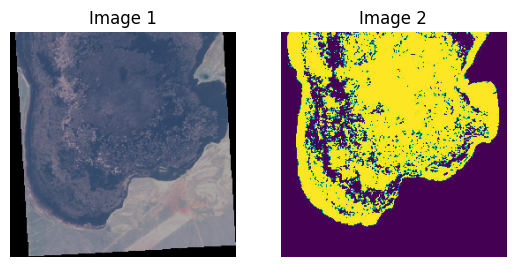

In [7]:
for m1,m2 in train_gen:
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(m1[0])
    plt.title('Image 1')
    plt.axis('off')  # Hide axes

    # Plot second image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(m2[0])
    plt.title('Image 2')
    plt.axis('off')  # Hide axes

    # Display the images
    plt.show()
    break

In [8]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), dropout_rate=0.3):
    inputs = layers.Input(input_size)

    # First contraction block
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout_rate)(p1)

    # Second contraction block
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout_rate)(p2)

    # Third contraction block
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout_rate)(p3)

    # Bottom layer (bottleneck)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Dropout(dropout_rate)(c4)

    # First expansion block
    u5 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Dropout(dropout_rate)(c5)

    # Second expansion block
    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.Dropout(dropout_rate)(c6)

    # Third expansion block
    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.Dropout(dropout_rate)(c7)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    # Model creation
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model


In [9]:
model = unet_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ dropout_3[0][0] 

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25


I0000 00:00:1726395038.329927     103 service.cc:145] XLA service 0x7891240033a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726395038.329988     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726395068.414524     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5843 - loss: 0.6185 - val_accuracy: 0.6829 - val_loss: 0.5287
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 515ms/step - accuracy: 0.6888 - loss: 0.5196 - val_accuracy: 0.6916 - val_loss: 0.5070
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 482ms/step - accuracy: 0.6997 - loss: 0.5019 - val_accuracy: 0.7116 - val_loss: 0.4862
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 443ms/step - accuracy: 0.7231 - loss: 0.4727 - val_accuracy: 0.7342 - val_loss: 0.4475
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.7196 - loss: 0.4705 - val_accuracy: 0.7476 - val_loss: 0.4329
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 316ms/step - accuracy: 0.6958 - loss: 0.4940 - val_accuracy: 0.7196 - val_loss: 0.4518
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 0.7305 - loss: 0.4589 - val_accuracy: 0.7458 - val_loss: 0.4337
Epoch 8/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 325ms/step - accuracy: 0.7460 - loss: 0.4360 - val_accuracy: 0.7433 - va

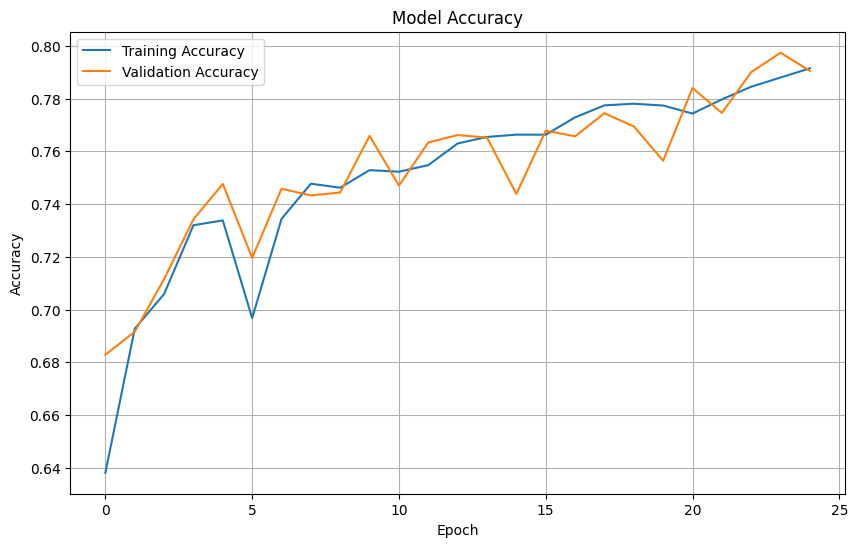

In [11]:
import matplotlib.pyplot as plt

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate steps per epoch for training and validation
steps_per_epoch = (int(len(image_files)/3))//BATCH_SIZE  # Ensure it's the number of batches, not just the number of images
validation_steps = (int(len(image_files)/3))//BATCH_SIZE   # Assuming you have a list or array of validation files

# Train the model and store the training history
history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=25,
                    validation_data=test_gen,
                    validation_steps=validation_steps)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


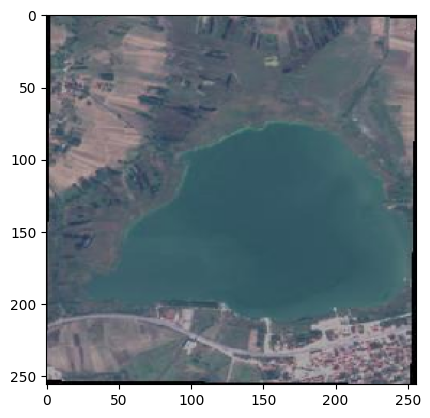

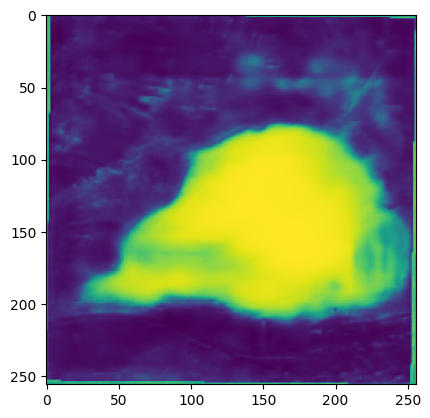

In [12]:
for m1,m2 in train_gen:
    pred = model.predict(m1)
    plt.imshow(m1[0])
    plt.show()
    plt.imshow(pred[0])
    break